Importing Libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings

# # Suppress warnings
# warnings.filterwarnings("ignore")

In [97]:
# Load data set

raw_data_dir = Path('../data/raw/processed')

Training_df = pd.read_csv(raw_data_dir/'deduplicated-training-with-medical-specialty.csv')
Testing_df = pd.read_csv(raw_data_dir/'testing-with-medical-specialty.csv')

# Assign features (X) and target (Y)
X_train = Training_df.drop(columns=['prognosis', 'medical_specialty'])
y_train = Training_df['medical_specialty']

X_test = Testing_df.drop(columns=['prognosis', 'medical_specialty'])
y_test = Testing_df['medical_specialty']

# Define the ModelPipeline class
class ModelPipeline:
    def __init__(self, model_type='logistic_regression'):
        """
        Initialize the pipeline with the chosen model type.
        param model_type: 'logistic_regression' or 'random_forest'
        """
        self.model_type = model_type
        self.label_encoder = LabelEncoder()

        # Select the prediction model with default parameters
        if self.model_type == 'logistic_regression':
            self.model = LogisticRegression(max_iter=1000, C=0.1)  # Stronger regularization
        elif self.model_type == 'random_forest':
            self.model = RandomForestClassifier(
                n_estimators=50, max_depth=10, max_features='sqrt', random_state=42
            )  # Reduced complexity
        else:
            raise ValueError("Invalid model type. Choose 'logistic_regression' or 'random_forest'.")

        # Create the pipeline with feature selection
        self.pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=20)),  # Select top 20 features
            ('classifier', self.model)
        ])

    def fit(self, X_train, y_train):
        """
        Fit the pipeline to the training data.
        param X_train: Features for training
        param y_train: Target labels for training
        """
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        self.pipeline.fit(X_train, y_train_encoded)

    def predict(self, X_test):
        """
        Predict using the pipeline.
        param X_test: Features for testing
        return: Predicted labels (decoded)
        """
        y_pred_encoded = self.pipeline.predict(X_test)
        return self.label_encoder.inverse_transform(y_pred_encoded)

    def score(self, X_test, y_test):
        """
        Score the pipeline using test data.
        param X_test: Features for testing
        param y_test: Target labels for testing
        return: Accuracy score
        """
        y_test_encoded = self.label_encoder.transform(y_test)
        return self.pipeline.score(X_test, y_test_encoded)


# Initialize and evaluate the Logistic Regression pipeline
pipeline_lr = ModelPipeline(model_type='logistic_regression')
pipeline_lr.fit(X_train, y_train)
lr_accuracy = pipeline_lr.score(X_test, y_test)
print("Logistic Regression Accuracy:", lr_accuracy)

# Initialize and evaluate the Random Forest pipeline
pipeline_rf = ModelPipeline(model_type='random_forest')
pipeline_rf.fit(X_train, y_train)
rf_accuracy = pipeline_rf.score(X_test, y_test)
print("Random Forest Accuracy:", rf_accuracy)

# View transformed features (X_train) after the pipeline

# Fit the pipeline
pipeline_lr.fit(X_train, y_train)

# Extract the transformed data step by step
# Step 1: After the imputer
X_imputed = pipeline_lr.pipeline.named_steps['imputer'].transform(X_train)

# Step 2: After scaling
X_scaled = pipeline_lr.pipeline.named_steps['scaler'].transform(X_imputed)

# Step 3: After feature selection
X_selected = pipeline_lr.pipeline.named_steps['feature_selection'].transform(X_scaled)

# # Print shapes to understand the transformations
# print("Original X_train shape:", X_train.shape)
# print("After imputation:", X_imputed.shape)
# print("After scaling:", X_scaled.shape)
# print("After feature selection:", X_selected.shape)

# # If you want to inspect the final transformed data:
# print("Final transformed X_train after the pipeline:")
# print(X_selected)

Logistic Regression Accuracy: 0.7380952380952381
Random Forest Accuracy: 0.7380952380952381


LOGISTIC REGRESSION:
Logistic Regression Test Accuracy: 0.7381


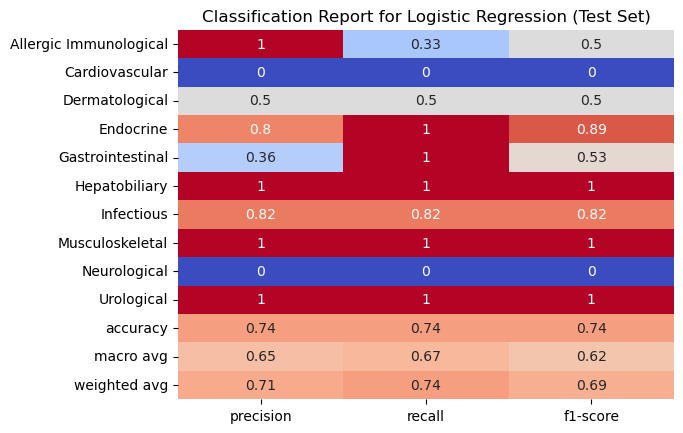

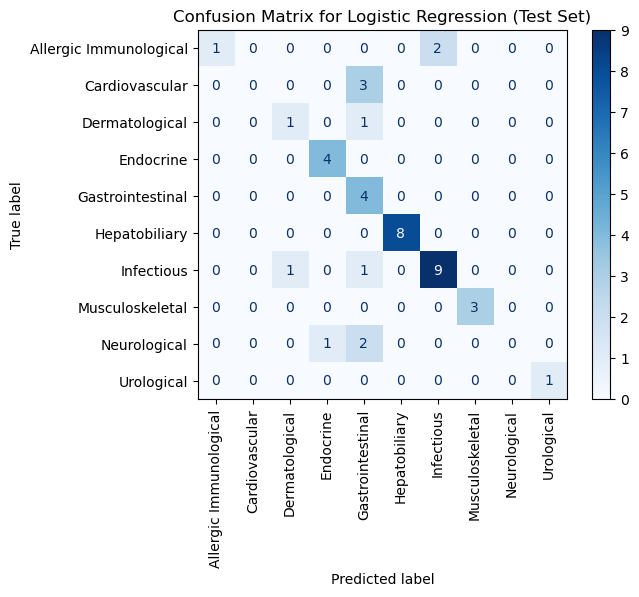

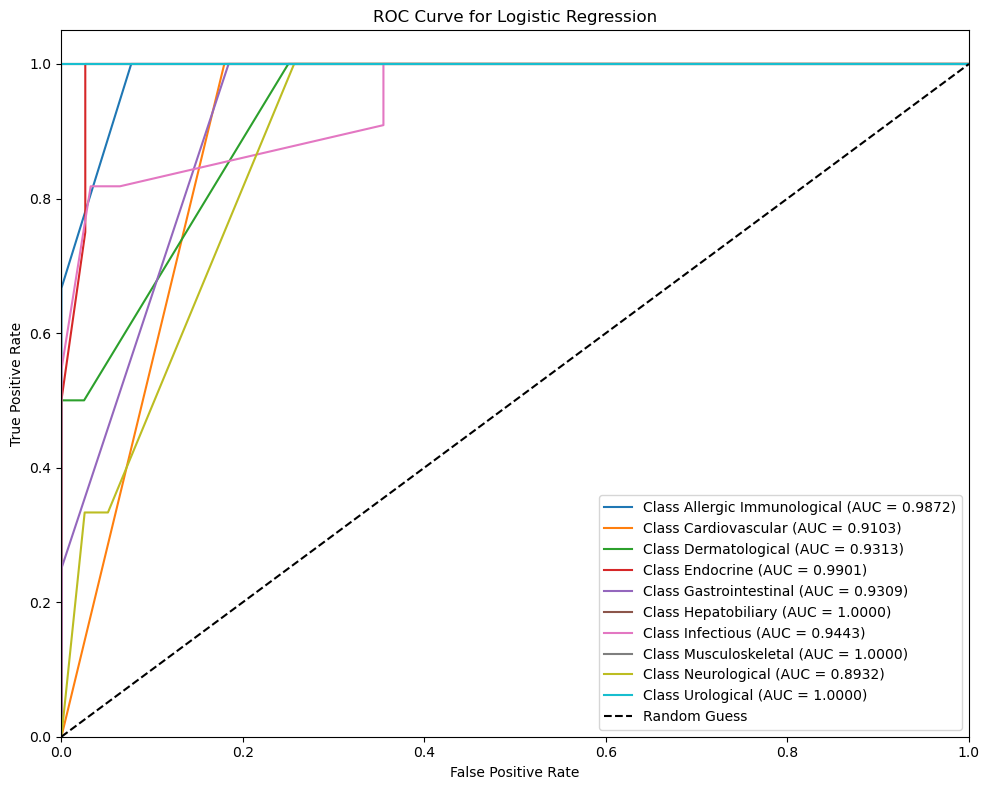


Logistic Regression Mean LOOCV Accuracy: 0.7730


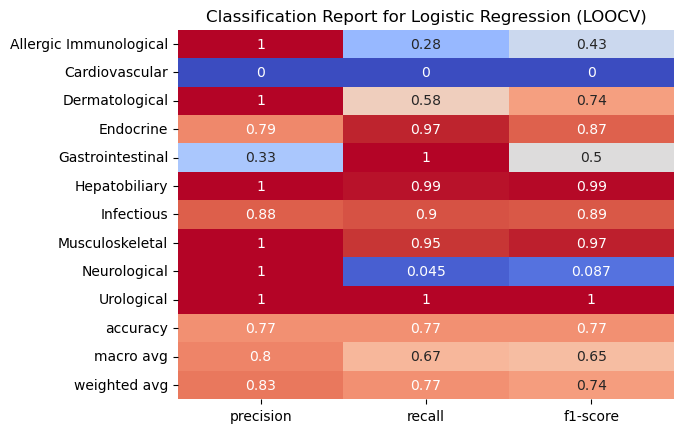

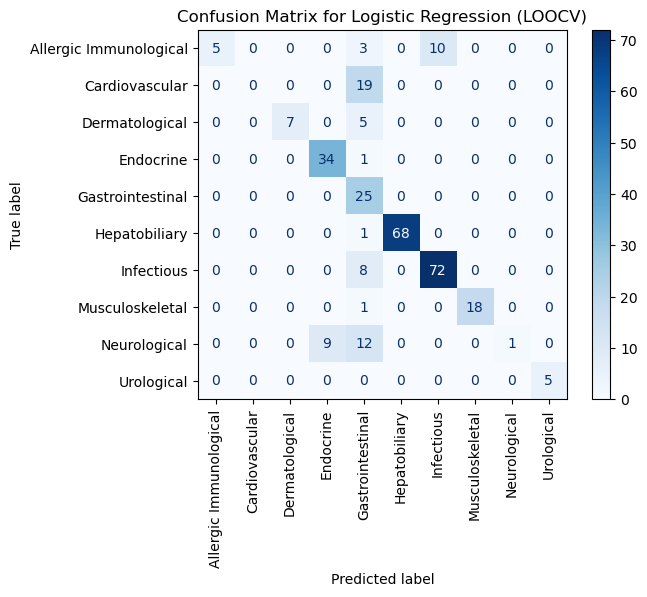


RANDOM FOREST:
Random Forest Test Accuracy: 0.7381


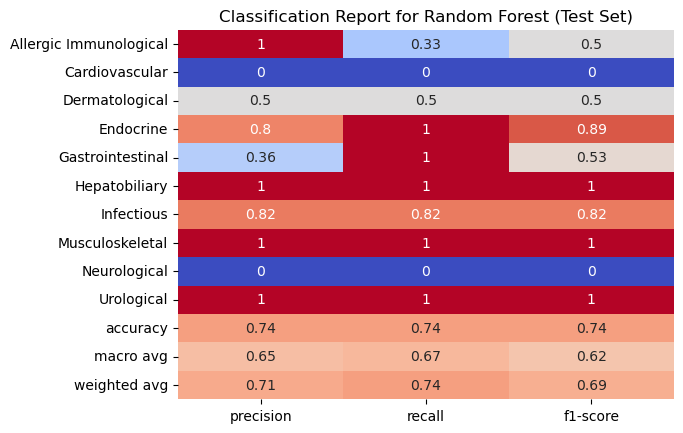

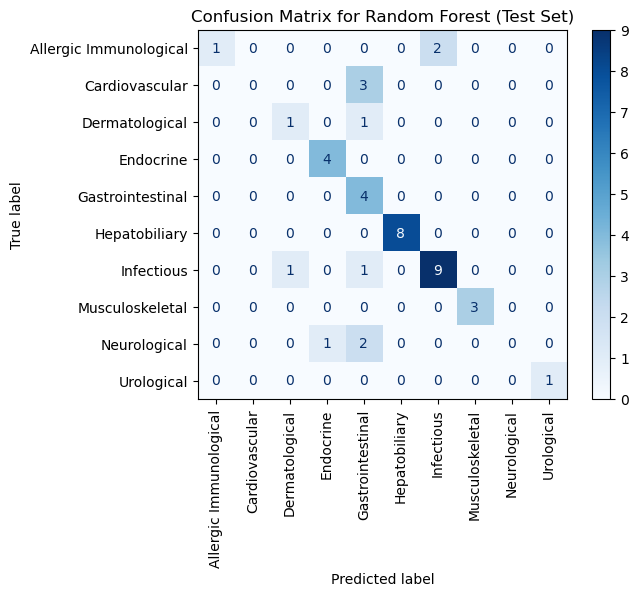


Random Forest Mean LOOCV Accuracy: 0.6974


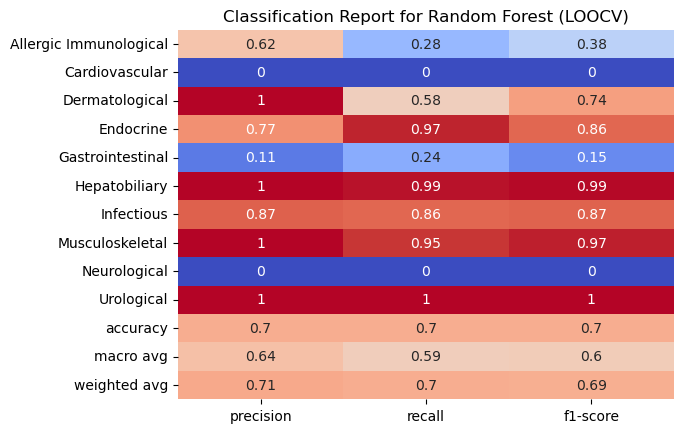

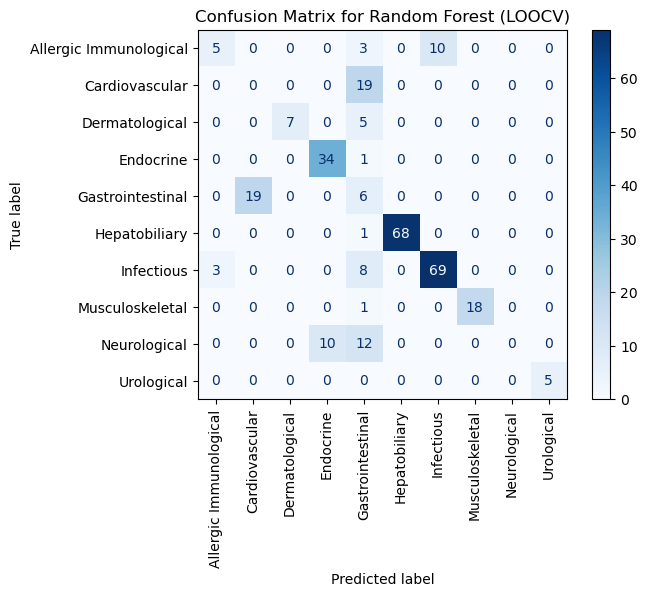

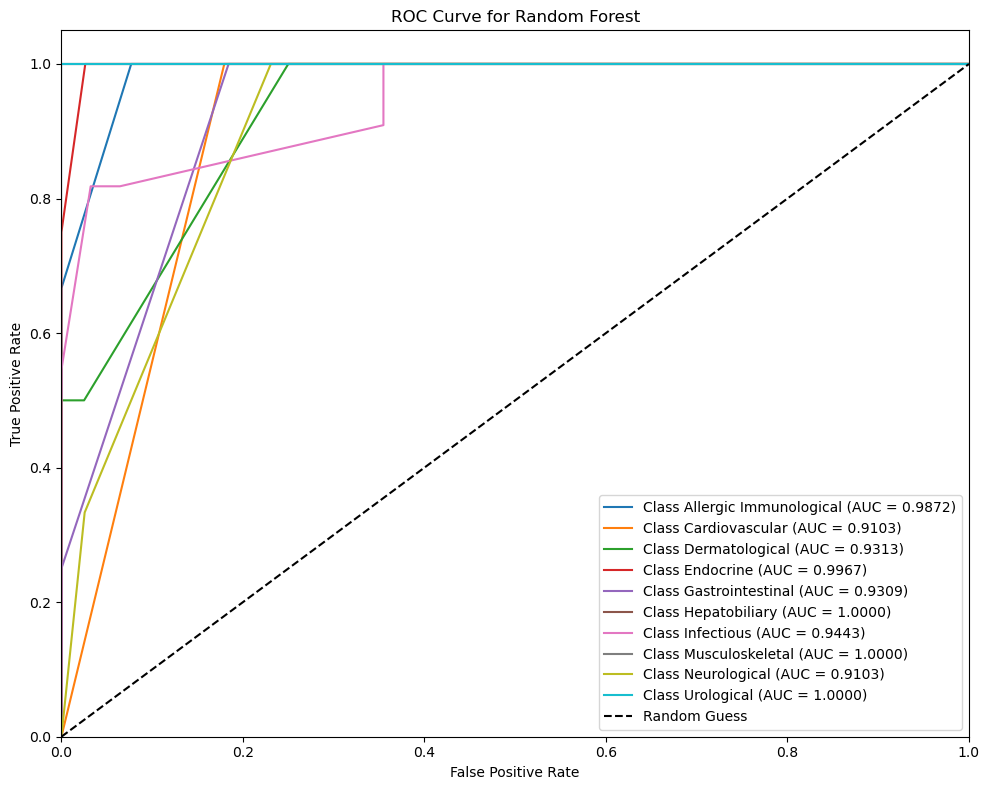

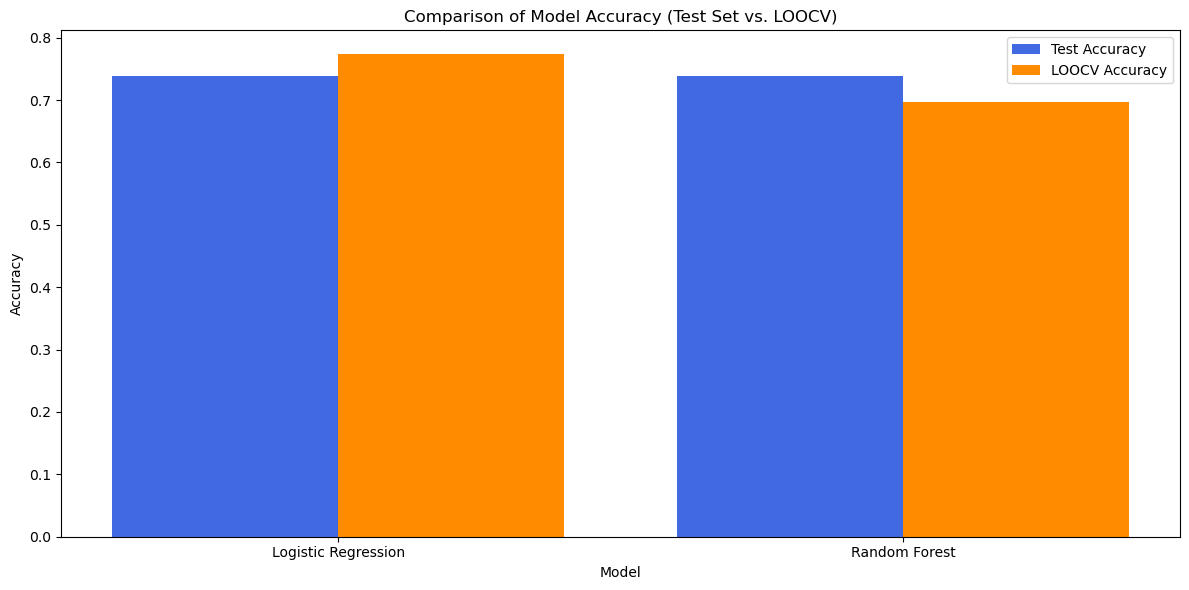

In [100]:
# # Import required libraries
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# from sklearn.model_selection import LeaveOneOut

# Function to evaluate model on the test set and generate plots
def evaluate_model_with_plots(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, target_names=pipeline.label_encoder.classes_)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm', cbar=False)
    plt.title(f"Classification Report for {model_name} (Test Set)")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')  # Plot with counts
    plt.title(f"Confusion Matrix for {model_name} (Test Set)")
    plt.xticks(rotation=90)
    plt.show()

    return accuracy

# Function to evaluate model using LOOCV and generate plots
def leave_one_out_validation_with_plots(pipeline, X, y, model_name):
    loo = LeaveOneOut()
    y_encoded = pipeline.label_encoder.fit_transform(y)
    accuracies = []
    all_true_labels = []
    all_pred_labels = []

    for train_index, test_index in loo.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y_encoded[train_index], y_encoded[test_index]

        # Fit and predict
        pipeline.pipeline.fit(X_train, y_train)
        y_pred = pipeline.pipeline.predict(X_val)

        accuracies.append(accuracy_score([y_val], [y_pred]))
        all_true_labels.append(y_val[0])
        all_pred_labels.append(y_pred[0])

    mean_accuracy = np.mean(accuracies)
    print(f"\n{model_name} Mean LOOCV Accuracy: {mean_accuracy:.4f}")

    # Classification Report
    report = classification_report(all_true_labels, all_pred_labels, output_dict=True, target_names=pipeline.label_encoder.classes_)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm', cbar=False)
    plt.title(f"Classification Report for {model_name} (LOOCV)")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {model_name} (LOOCV)")
    plt.xticks(rotation=90)
    plt.show()

    return mean_accuracy

# Function to plot ROC Curve and AUC
def plot_roc_auc(pipeline, X_test, y_test, model_name):
    # Binarize the labels for multi-class
    y_encoded = pipeline.label_encoder.fit_transform(y_test)
    y_binarized = label_binarize(y_encoded, classes=np.arange(len(pipeline.label_encoder.classes_)))

    # Get probabilities for ROC curve from the underlying model
    if hasattr(pipeline.pipeline, "predict_proba"):
        y_prob = pipeline.pipeline.predict_proba(X_test)
    else:
        raise AttributeError(f"The underlying model in {model_name} does not support probability prediction.")

    # One-vs-Rest ROC Curve
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(y_binarized.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(len(pipeline.label_encoder.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {pipeline.label_encoder.classes_[i]} (AUC = {roc_auc[i]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

##### LOGISTIC REGRESSION #####

# Logistic Regression Evaluation
print("LOGISTIC REGRESSION:")
lr_accuracy = evaluate_model_with_plots(pipeline_lr, X_test, y_test, "Logistic Regression")

# Plot logistic regression roc auc
plot_roc_auc(pipeline_lr, X_test, y_test, "Logistic Regression")

# Logistic Regression LOOCV
lr_loocv_accuracy = leave_one_out_validation_with_plots(pipeline_lr, X_train, y_train, "Logistic Regression")


##### RANDOM FOREST #####
# Random Forest Evaluation
print("\nRANDOM FOREST:")
rf_accuracy = evaluate_model_with_plots(pipeline_rf, X_test, y_test, "Random Forest")

# Random Forest LOOCV
# print("\nRandom Forest LOOCV:")
rf_loocv_accuracy = leave_one_out_validation_with_plots(pipeline_rf, X_train, y_train, "Random Forest")

# Plot Random Forest roc auc
plot_roc_auc(pipeline_rf, X_test, y_test, "Random Forest")


##### ACCURACY COMPARISON #####
# --- Plot Comparison of Model Accuracies ---
plt.figure(figsize=(12, 6))
model_names = ['Logistic Regression', 'Random Forest']
test_accuracies = [lr_accuracy, rf_accuracy]
loocv_accuracies = [lr_loocv_accuracy, rf_loocv_accuracy]

x = np.arange(len(model_names))
plt.bar(x - 0.2, test_accuracies, width=0.4, label='Test Accuracy', color='royalblue')
plt.bar(x + 0.2, loocv_accuracies, width=0.4, label='LOOCV Accuracy', color='darkorange')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy (Test Set vs. LOOCV)")
plt.xticks(x, model_names)
plt.legend()
plt.tight_layout()
plt.show()